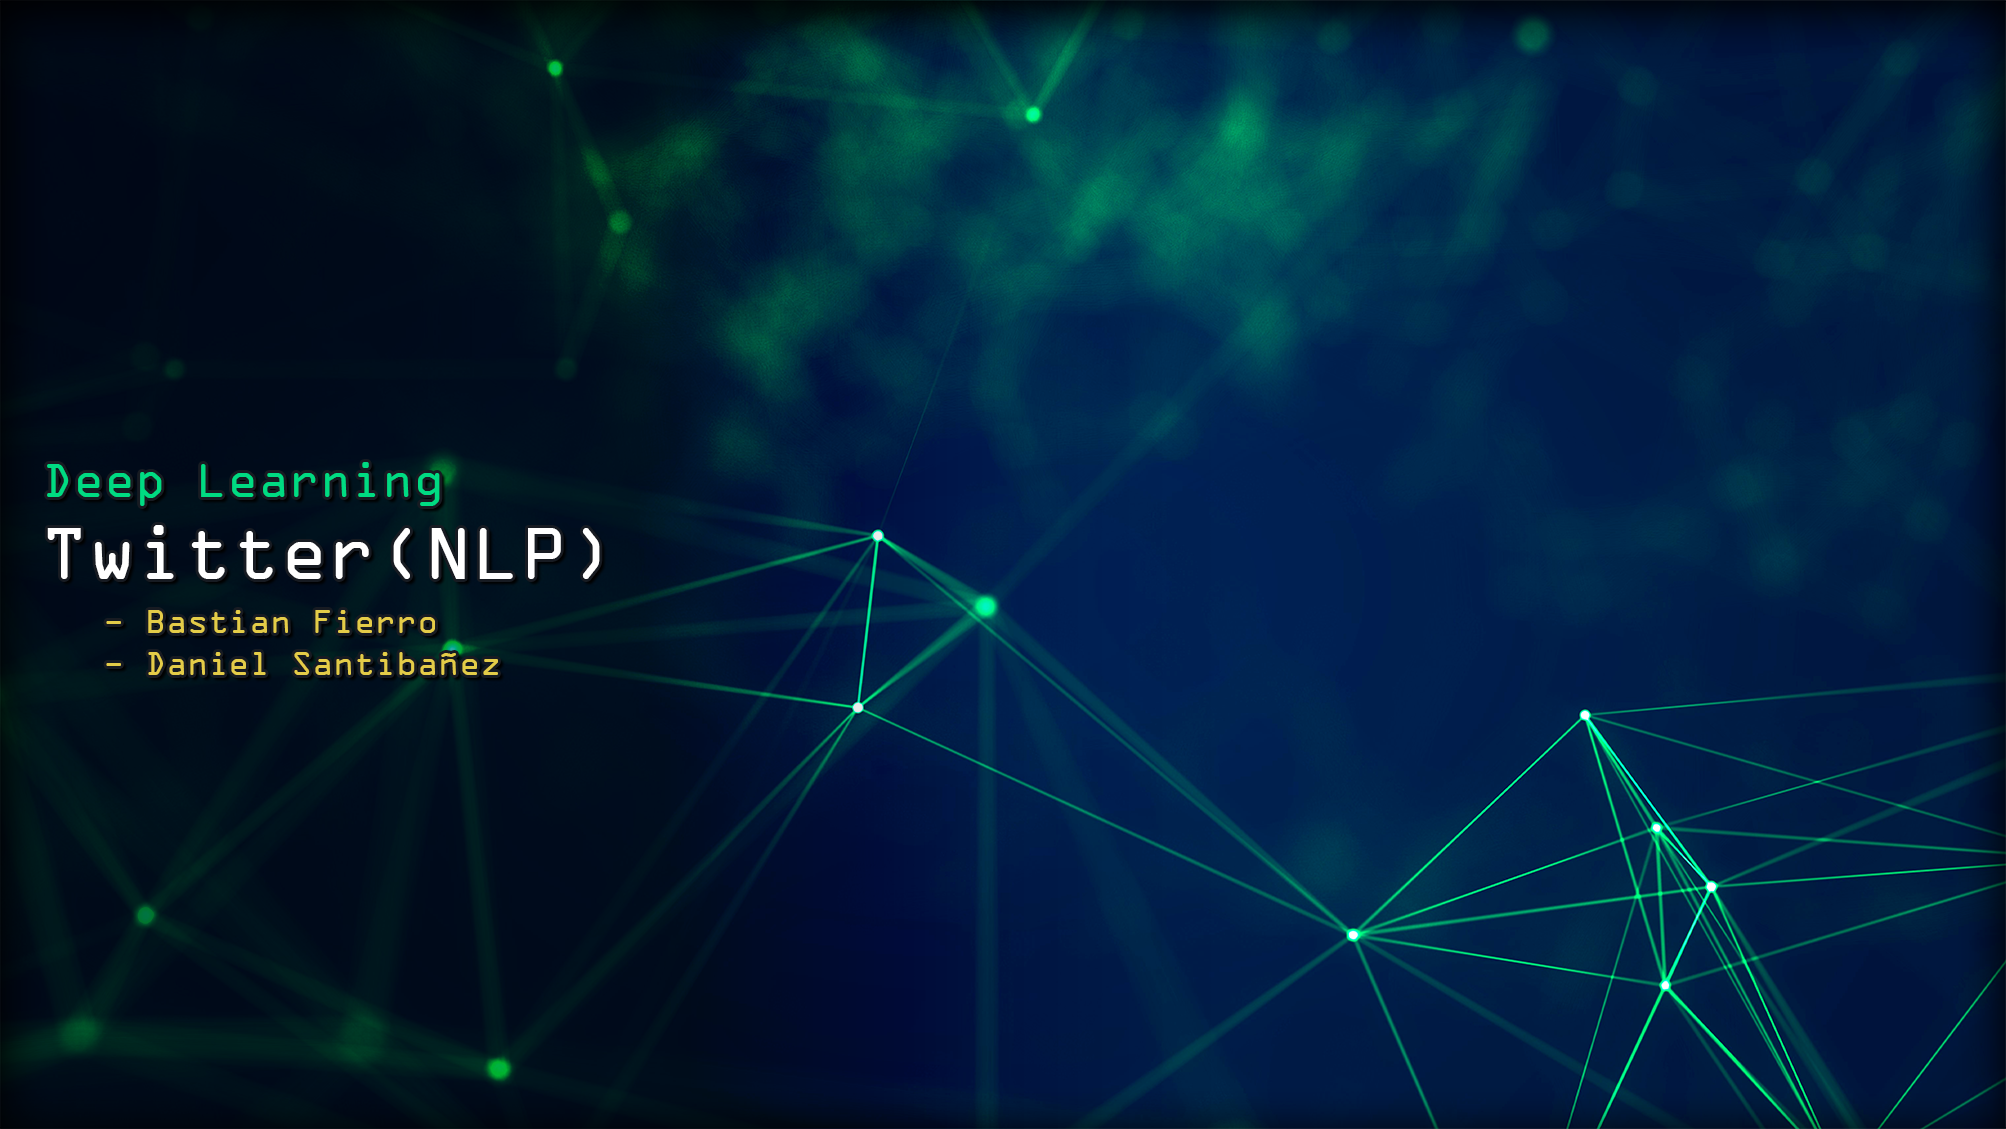

# Experimental

## Experimental (Uso del GPU local)

In [ ]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
import tensorflow as tf

# Set the policy to mixed precision
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Enable XLA
tf.config.optimizer.set_jit(True)

# Configuración para permitir la asignación de memoria dinámica
gpus = tf.config.list_physical_devices('GPU')


if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # Memory growth must be set at program startup
    print(e)

# Other code that you want to run


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4080, compute capability 8.9


In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4080 (UUID: GPU-fb571f41-77a6-42b8-37c2-a5f686bf55db)


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


# Cargar los datos (10 puntos):


## Importar las librerias

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras_preprocessing.sequence import pad_sequences
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer

## Carga de datos

In [ ]:

import pandas as pd

# Define column names
column_names = ["target", "tweet"]

# Load CSV file
df = pd.read_csv('/tf-bastian/TweetsClasificacion.csv',  names=column_names,sep=';')

# Display the DataFrame
print(df.head())


     target                                              tweet
0  Positivo  I LOVE u guys r the best!!  http://bkite.com/0...
1  Positivo  im meeting up with one of my besties tonight! ...
2  Positivo  Being sick can be really cheap when it hurts t...
3  Positivo                    he has that effect on everyone 
4  Positivo  You can tell him that I just burst out laughin...


## Análisis de estructura y distribución de datos

In [ ]:

# 1. Estructura de datos
print("Estructura de datos:")
print("Número de filas:", df.shape[0])
print("Número de columnas:", df.shape[1])
print()

# 2. Variables/Características
print("Variables/Características:")
print(df.dtypes)
print()

# 3. Muestra de datos
print("Muestra de datos:")
print(df.head())  # Muestra los primeros registros, puedes ajustar la cantidad con head(n) donde n es el número de registros a mostrar
print()

# Verificar las columnas con valores nulos
columnas_con_nulos = df.columns[df.isnull().any()].tolist()
print("Columnas con valores nulos:")
print(columnas_con_nulos)

#Analisis de distribución

def count_target_values(df):
  target_counts = {}
  for target in df['target'].unique():
    target_counts[target] = df['target'].value_counts()[target]

  return target_counts

print('Target:')
print(count_target_values(df))


Estructura de datos:
Número de filas: 1599997
Número de columnas: 2

Variables/Características:
target    object
tweet     object
dtype: object

Muestra de datos:
     target                                              tweet
0  Positivo  I LOVE u guys r the best!!  http://bkite.com/0...
1  Positivo  im meeting up with one of my besties tonight! ...
2  Positivo  Being sick can be really cheap when it hurts t...
3  Positivo                    he has that effect on everyone 
4  Positivo  You can tell him that I just burst out laughin...

Columnas con valores nulos:
[]
Target:
{'Positivo': 799998, 'Negativo': 799999}


# Preprocesamiento de Datos (40 puntos)

## Funciones auxiliares:


In [ ]:
#Indices to Text
"""
Esta función toma una lista de índices y devuelve el texto correspondiente.
Para cada índice en la lista de entrada, busca la palabra correspondiente en el
diccionario index_word y luego une todas las palabras en una cadena de texto.
"""
def indices_to_text(indices):
    words = [index_word[i] for i in indices]
    text = ' '.join(words)
    return text

#Text to indices
"""
Esta función realiza la operación inversa de indices_to_text().
Toma una cadena de texto como entrada, la divide en palabras y luego convierte
cada palabra en su correspondiente índice usando el diccionario word_index.
Si una palabra no está en el diccionario word_index, le asigna el índice 2,
que generalmente corresponde a una palabra desconocida en NLP.
"""
def text_to_indices(text):
    words = text.split()
    indices = [word_index[w] if w in word_index else 2 for w in words]
    return indices

#Text to model input
"""
Esta función convierte una cadena de texto en una entrada de modelo adecuada.
Primero, convierte el texto en índices usando la función text_to_indices(),
luego remodela la lista de índices en una matriz de numpy de la forma (1, -1).
Finalmente, utiliza la función pad_sequences para asegurarse de que la
secuencia tenga una longitud fija (max_length). Las secuencias más cortas que
max_length son rellenadas con ceros al principio.
"""
def text_to_model_input(text, max_length=80):
    indices = text_to_indices(text)
    X = np.array(indices).reshape(1,-1)
    X = keras.preprocessing.sequence.pad_sequences(X, maxlen=max_length)
    return X

#Sequence to text
"""
Esta función toma una secuencia de índices y la convierte en texto. Se salta
los índices que son cero (que normalmente son usados para el relleno en NLP),
y para cada índice no cero, busca la palabra correspondiente en el diccionario
reverse_word_map y luego une todas las palabras en una cadena de texto.
"""
def sequence_to_text(sequence):
    words = [reverse_word_map.get(letter) for letter in sequence if letter != 0]
    return ' '.join(words)

## Preprocesamiento de los datos:


In [ ]:
# nltk.download('wordnet')
"""
Descargamos el lematizador de WordNet a través de NLTK. WordNet es una base
de datos léxica del inglés. Los lematizadores intentan reducir las palabras
a su raíz o forma base.
"""
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# df.dropna()
"""
Eliminamos las filas que contienen valores nulos en el DataFrame df.
En este caso, no habían nulos en el dataframe.
"""
df = df.dropna()
df = df.reset_index(drop=True)

# np.where
"""
Codificamos el sentimiento positivo como 1 y
el negativo como 0 en la columna 'target' del DataFrame df.
"""
df['target'] = np.where(df['target']=='Positivo', 1, 0)

# re.sub(r'http\S+|www.\S+', '', x, flags=re.MULTILINE)
"""
Eliminamos las URLs de la columna 'tweet'
utilizando una expresión regular para encontrarlas.
"""
df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', x, flags=re.MULTILINE))

# re.sub(r'\d+', '', x)
"""
Eliminamos los números de la columna 'tweet'
utilizando una expresión regular para encontrarlos.
"""
df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'\d+', '', x))

# re.sub(r'@\w+|#', '', x)
"""
Eliminamos las menciones y hashtags de la columna 'tweet'
utilizando una expresión regular para encontrarlos.
"""
df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'@\w+|#', '', x))

# x.lower()
"""
Convertimos todo el texto en la columna 'tweet' a minúsculas.
"""
df['tweet'] = df['tweet'].apply(lambda x: x.lower())

# x.translate(str.maketrans('', '', string.punctuation))
"""
Eliminamos toda la puntuación del texto en la columna 'tweet'
utilizando la función translate.
"""
df['tweet'] = df['tweet'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# lemmatizer.lemmatize(word)
"""
Lematizamos cada palabra del texto en la columna 'tweet'.
Esto significa que convertimos cada palabra a su forma base o raíz.
"""
df['tweet'] = df['tweet'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# keras.preprocessing.text.Tokenizer()
"""
Inicializamos el Tokenizer de Keras. Este es un clase que permite vectorizar
un corpus de texto, convirtiendo cada texto en una secuencia de enteros.
"""
tokenizer = keras.preprocessing.text.Tokenizer()

# tokenizer.fit_on_texts()
"""
Actualizamos el vocabulario interno basado en una lista de textos.
En este caso, los tweets que hemos limpiado y preprocesado.
"""
tokenizer.fit_on_texts(df['tweet'].values)

# tokenizer.word_index
"""
Una vez que el Tokenizer ha sido ajustado a los datos, esta propiedad
contiene el mapeo de las palabras a su respectivo índice en el vocabulario.
"""
word_index = tokenizer.word_index

# {v:k for k,v in word_index.items()}
"""
Creamos un diccionario inverso que mapea los índices a sus respectivas palabras.
 Esto será útil más adelante para convertir secuencias de índices a texto.
"""
index_word = {v:k for k,v in word_index.items()}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Convertir textos a secuencias y dividir los datos en conjuntos de entrenamiento y prueba:

In [ ]:
# tokenizer.texts_to_sequences()
"""
Este método convierte cada texto en una secuencia de enteros. Cada entero es
el índice de una palabra en el diccionario que se ha aprendido del corpus total.
"""
X = tokenizer.texts_to_sequences(df['tweet'].values)

# df['target'].values
"""
Extraemos los valores del objetivo (target) del DataFrame df. Estos son las
etiquetas de los tweets, que serán las salidas esperadas del modelo.
"""
Y = df['target'].values

# max_length
"""
Definimos la longitud máxima para las secuencias. Las secuencias más cortas
que esta longitud serán rellenadas con ceros al principio y las más largas
serán truncadas.
"""
max_length = 80

# pad_sequences()
"""
Esta función se usa para asegurarse de que todas las secuencias en la lista
tienen la misma longitud. Lo hace rellenando las secuencias más cortas con
ceros al principio y truncando las más largas.
"""
X = pad_sequences(X, maxlen=max_length)

# train_test_split()
"""
Dividimos los datos en conjuntos de entrenamiento y prueba. El 20% de los datos
se utilizará para la prueba y el 80% para el entrenamiento. También definimos
una semilla (random_state) para la reproducibilidad de los resultados.
"""
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# len(word_index) + 1
"""
Calculamos el número total de palabras únicas en el corpus de tweets,
añadiendo 1 porque Keras requiere espacio para un token especial
de 'fuera de vocabulario'.
"""
num_words = len(word_index) + 1


# Entrenamiento de Modelos RNN (20 puntos) y LSTM (20 puntos)

## Crear el modelo RNN

In [ ]:
from keras.layers import SimpleRNN
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization

# Reduce learning rate cuando la métrica deja de mejorar
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=0.0001)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Estructura con batch normalization
modelRNN = Sequential()
modelRNN.add(Embedding(num_words, 128, input_length=max_length))
modelRNN.add(SimpleRNN(64, dropout=0.55, recurrent_dropout=0.55))
modelRNN.add(BatchNormalization())
modelRNN.add(Dense(1, activation='sigmoid'))

# Compilar modelo
modelRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Entrenar el modelo
# Usaremos un batch size de 60000.
"""
El uso de un tamaño de lote (batch size) alto puede beneficiar el rendimiento
de entrenamiento en modelos de aprendizaje profundo debido a varias razones:

Eficiencia en la utilización de GPU: Las GPUs modernas, como en este caso la
RTX 4080 con 16 GB de VRAM, pueden procesar múltiples muestras en paralelo.
Al aumentar el tamaño del lote, se pueden aprovechar al máximo los recursos
de la GPU y reducir la sobrecarga de comunicación entre la GPU y la CPU.
Esto puede acelerar el entrenamiento, ya que se realizan cálculos en paralelo
para un mayor número de muestras antes de actualizar los pesos del modelo.

Estabilidad del gradiente: Con un tamaño de lote mayor, el gradiente calculado
en cada paso de actualización de los pesos se basa en un promedio de los
gradientes de todas las muestras del lote. Esto puede ayudar a estabilizar
el proceso de optimización y hacer que los pasos de actualización sean más
consistentes. Además, el ruido inherente a los gradientes individuales
se reduce, lo que puede conducir a una convergencia más rápida y a una
mejor generalización del modelo.
"""
history_dictRNN = modelRNN.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=60000, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
22/22 [==============================] - 19s 759ms/step - loss: 0.8690 - accuracy: 0.5069 - val_loss: 0.6715 - val_accuracy: 0.6112 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 17s 774ms/step - loss: 0.8049 - accuracy: 0.5223 - val_loss: 0.6552 - val_accuracy: 0.6416 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 16s 733ms/step - loss: 0.7578 - accuracy: 0.5376 - val_loss: 0.6424 - val_accuracy: 0.6560 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - 16s 727ms/step - loss: 0.7257 - accuracy: 0.5526 - val_loss: 0.6310 - val_accuracy: 0.6654 - lr: 0.0010
Epoch 5/100
22/22 [==============================] - 16s 731ms/step - loss: 0.7028 - accuracy: 0.5669 - val_loss: 0.6186 - val_accuracy: 0.6792 - lr: 0.0010
Epoch 6/100
22/22 [==============================] - 15s 704ms/step - loss: 0.6847 - accuracy: 0.5825 - val_loss: 0.6071 - val_accuracy: 0.6869 - lr: 0.0010
Epoch 7/100
22/22 [==============================] - 16s 7

### Gráficos

Last epoch - loss: 0.541, accuracy: 0.731, validation loss: 0.513, validation accuracy: 0.773


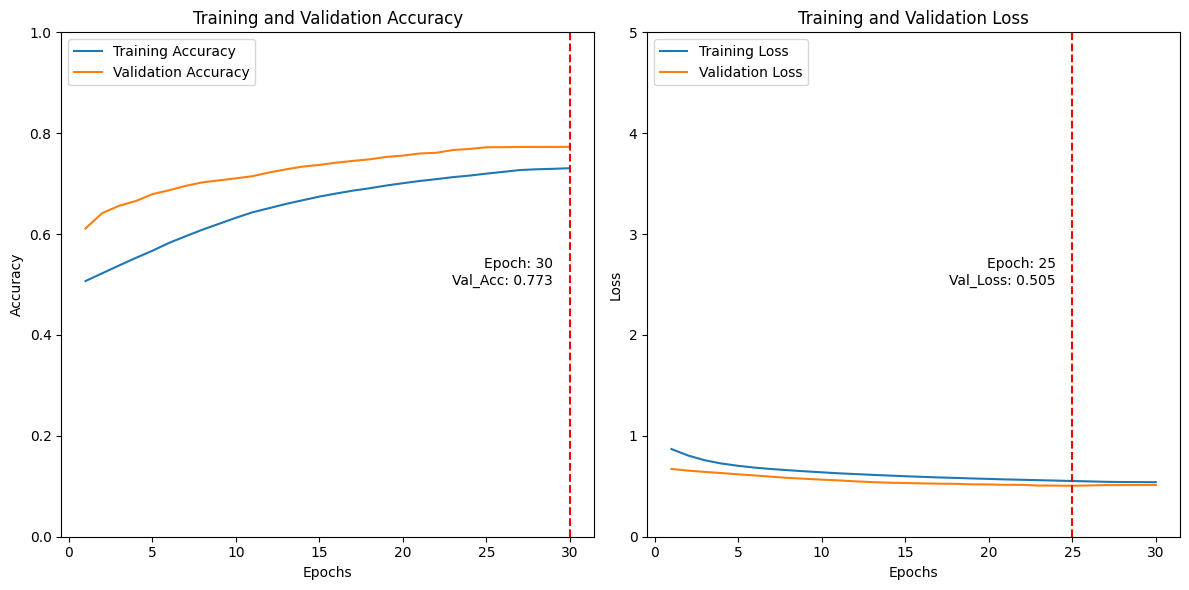

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

history_dictRNN = history_dictRNN.history
last_epoch_loss = round(history_dictRNN['loss'][-1],3)
last_epoch_accuracy = round(history_dictRNN['accuracy'][-1],3)
last_epoch_val_loss = round(history_dictRNN['val_loss'][-1],3)
last_epoch_val_accuracy = round(history_dictRNN['val_accuracy'][-1],3)

print(f"Last epoch - loss: {last_epoch_loss}, accuracy: {last_epoch_accuracy}, validation loss: {last_epoch_val_loss}, validation accuracy: {last_epoch_val_accuracy}")

epochs = range(1, len(history_dictRNN['accuracy']) + 1)

# Grafica del Accuracy
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de Training y Validation Accuracy
axs[0].plot(epochs, history_dictRNN['accuracy'], label='Training Accuracy')
axs[0].plot(epochs, history_dictRNN['val_accuracy'], label='Validation Accuracy')
max_val_acc_epoch = np.argmax(history_dictRNN['val_accuracy']) + 1
max_val_acc = history_dictRNN['val_accuracy'][max_val_acc_epoch - 1]
axs[0].axvline(x=max_val_acc_epoch, color='r', linestyle='--')
axs[0].text(max_val_acc_epoch-1, 0.5, f'Epoch: {max_val_acc_epoch}\nVal_Acc: {max_val_acc:.3f}', horizontalalignment='right')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].set_ylim([0, 1])

# Gráfico de Training y Validation Loss
axs[1].plot(epochs, history_dictRNN['loss'], label='Training Loss')
axs[1].plot(epochs, history_dictRNN['val_loss'], label='Validation Loss')
min_val_loss_epoch = np.argmin(history_dictRNN['val_loss']) + 1
min_val_loss = history_dictRNN['val_loss'][min_val_loss_epoch - 1]
axs[1].axvline(x=min_val_loss_epoch, color='r', linestyle='--')
axs[1].text(min_val_loss_epoch-1, 2.5, f'Epoch: {min_val_loss_epoch}\nVal_Loss: {min_val_loss:.3f}', horizontalalignment='right')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].set_ylim([0, 5])

plt.tight_layout()  # Ajusta el espaciado entre los subplots
plt.show()


Este modelo tiene unos resultados bastante buenos, prediciendo la mayoría de las muestras (en la sección de abajo), y tuvo 2 errores. Aunque no se aprecian signos de underfitting, se puede ver que tiene indicios de overfitting al inicio en el gráfico de accuracy, pero esto se va minimizando con el paso de las épocas. Por ende, el modelo generaliza bien.

### Predicción

In [ ]:
# Construir un mapeo inverso de índice a palabra
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

# Muestras de texto
samples = [
    "I'm so happy today!", # Positivo
    "I really love this song", # Positivo
    "Best day ever!!!", # Positivo
    "omg this is amazeballs", # Positivo, Internet slang
    "Feeling on top of the world", # Positivo
    "I'm really pissed off right now", # Negativo
    "This is the worst thing ever", # Negativo
    "I can't stand this anymore", # Negativo
    "this sucks so bad", # Negativo, Informal language
    "I'm feeling really down", # Negativo
    "i dunno why im so upset", # Negativo, Typographical errors
    "im so over this", # Negativo, Typographical errors
    "Everything is just perfect", # Positivo
    "It's all going downhill", # Negativo
    "I'm overjoyed by the unexpected good news!", # Positivo
    "This book is a captivating masterpiece.", # Positivo
    "I'm frustrated with the lack of progress.", # Negativo
    "The sunset filled me with awe and joy.", # Positivo
    "I'm deeply disappointed in the outcome.", # Negativo
    "The documentary left me feeling melancholic.", # Negativo
    "I can't bear another letdown.", # Negativo
    "Dealing with uncertainty is frustrating.", # Negativo
    "The negativity is wearing me down.", # Negativo
    "I'm perplexed by the irrationality.", # Negativo
    "The sense of accomplishment is indescribable.", # Positivo
    "Everything fell apart, leaving me defeated." # Negativo
]

# Preprocesar las muestras de la misma manera que los datos de entrenamiento
samples = tokenizer.texts_to_sequences(samples)
samples_padded = pad_sequences(samples, maxlen=max_length)

# Realizar las predicciones
predictions = modelRNN.predict(samples_padded)

for i, prediction in enumerate(predictions):
    if prediction < 0.5:
        sentiment = 'Negativo'
    else:
        sentiment = 'Positivo'

    print(f'Texto: {sequence_to_text(samples[i])}' + f' ({sentiment})')




1/1 [==============================] - 0s 179ms/step
Texto: so happy today (Positivo)
Texto: i really love this song (Positivo)
Texto: best day ever (Positivo)
Texto: omg this is amazeballs (Positivo)
Texto: feeling on top of the world (Positivo)
Texto: really pissed off right now (Negativo)
Texto: this is the worst thing ever (Negativo)
Texto: i stand this anymore (Negativo)
Texto: this so bad (Negativo)
Texto: feeling really down (Negativo)
Texto: i dunno why im so upset (Negativo)
Texto: im so over this (Negativo)
Texto: everything is just perfect (Positivo)
Texto: all going downhill (Negativo)
Texto: overjoyed by the unexpected good news (Positivo)
Texto: this book is a captivating masterpiece (Positivo)
Texto: frustrated with the lack of progress (Positivo)
Texto: the sunset filled me with awe and joy (Positivo)
Texto: deeply disappointed in the outcome (Negativo)
Texto: the documentary left me feeling melancholic (Negativo)
Texto: i bear another letdown (Negativo)
Texto: dealing 

Se Equivocó en 'frustrated with the lack of progress' y 'perplexed by the irrationality'

## Crear el modelo LSTM:


In [ ]:
# Reduce learning rate cuando la métrica deja de mejorar
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=0.0001)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Definir la estructura del modelo
modelLSTM = Sequential()
modelLSTM.add(Embedding(num_words, 128, input_length=max_length))
modelLSTM.add(LSTM(64, dropout=0.55, recurrent_dropout=0.55))
modelLSTM.add(BatchNormalization())
modelLSTM.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
modelLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Entrenar el modelo
history_dictLSTM = modelLSTM.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=27000, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
48/48 [==============================] - 72s 1s/step - loss: 0.4737 - accuracy: 0.7790 - val_loss: 0.6579 - val_accuracy: 0.7985 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 69s 1s/step - loss: 0.4310 - accuracy: 0.8056 - val_loss: 0.6363 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 67s 1s/step - loss: 0.4030 - accuracy: 0.8205 - val_loss: 0.6153 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - 68s 1s/step - loss: 0.3793 - accuracy: 0.8323 - val_loss: 0.5933 - val_accuracy: 0.7962 - lr: 0.0010
Epoch 5/100
48/48 [==============================] - 69s 1s/step - loss: 0.3581 - accuracy: 0.8424 - val_loss: 0.5661 - val_accuracy: 0.8035 - lr: 0.0010
Epoch 6/100
48/48 [==============================] - 71s 1s/step - loss: 0.3410 - accuracy: 0.8509 - val_loss: 0.5405 - val_accuracy: 0.8013 - lr: 0.0010
Epoch 7/100
48/48 [==============================] - 68s 1s/step - loss: 0.3

### Gráficos

Last epoch - loss: 0.256, accuracy: 0.89, validation loss: 0.493, validation accuracy: 0.802


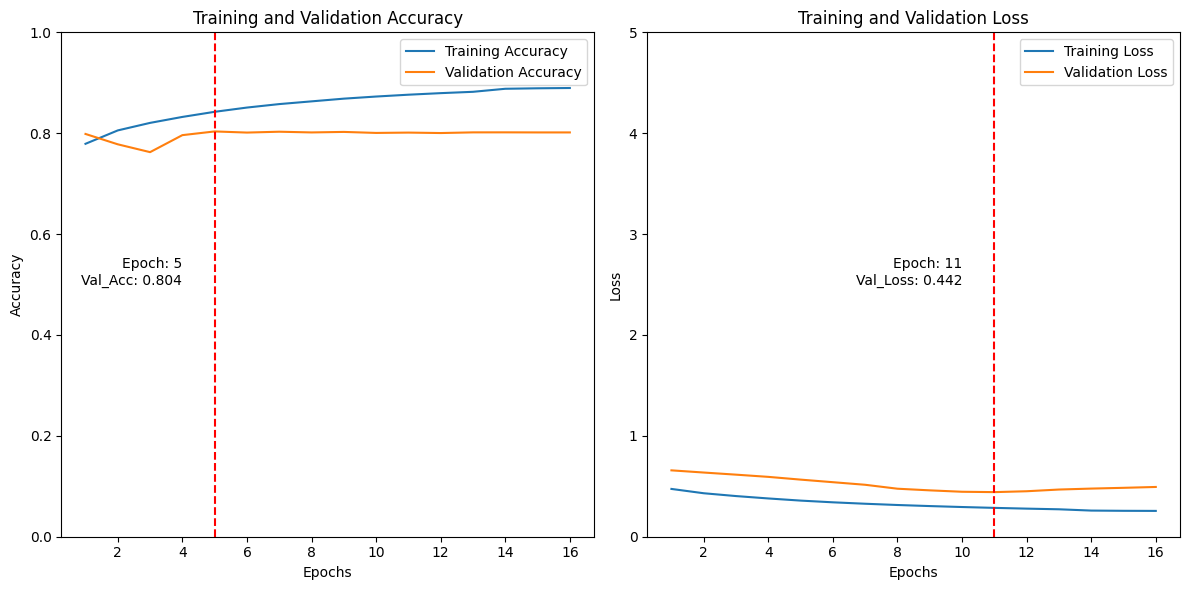

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

history_dictLSTM = history_dictLSTM.history
last_epoch_loss = round(history_dictLSTM['loss'][-1],3)
last_epoch_accuracy = round(history_dictLSTM['accuracy'][-1],3)
last_epoch_val_loss = round(history_dictLSTM['val_loss'][-1],3)
last_epoch_val_accuracy = round(history_dictLSTM['val_accuracy'][-1],3)

print(f"Last epoch - loss: {last_epoch_loss}, accuracy: {last_epoch_accuracy}, validation loss: {last_epoch_val_loss}, validation accuracy: {last_epoch_val_accuracy}")

epochs = range(1, len(history_dictLSTM['accuracy']) + 1)

# Grafica del Accuracy
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de Training y Validation Accuracy
axs[0].plot(epochs, history_dictLSTM['accuracy'], label='Training Accuracy')
axs[0].plot(epochs, history_dictLSTM['val_accuracy'], label='Validation Accuracy')
max_val_acc_epoch = np.argmax(history_dictLSTM['val_accuracy']) + 1
max_val_acc = history_dictLSTM['val_accuracy'][max_val_acc_epoch - 1]
axs[0].axvline(x=max_val_acc_epoch, color='r', linestyle='--')
axs[0].text(max_val_acc_epoch-1, 0.5, f'Epoch: {max_val_acc_epoch}\nVal_Acc: {max_val_acc:.3f}', horizontalalignment='right')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].set_ylim([0, 1])

# Gráfico de Training y Validation Loss
axs[1].plot(epochs, history_dictLSTM['loss'], label='Training Loss')
axs[1].plot(epochs, history_dictLSTM['val_loss'], label='Validation Loss')
min_val_loss_epoch = np.argmin(history_dictLSTM['val_loss']) + 1
min_val_loss = history_dictLSTM['val_loss'][min_val_loss_epoch - 1]
axs[1].axvline(x=min_val_loss_epoch, color='r', linestyle='--')
axs[1].text(min_val_loss_epoch-1, 2.5, f'Epoch: {min_val_loss_epoch}\nVal_Loss: {min_val_loss:.3f}', horizontalalignment='right')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].set_ylim([0, 5])

plt.tight_layout()  # Ajusta el espaciado entre los subplots
plt.show()


Este modelo, al igual que el anterior, tiene unos resultados bastante buenos, prediciendo la mayoría de las muestras (en la sección de abajo), pero a diferencia del anterior, tuvo solo 1 error a diferencia de 2 errores que tuvo el anterior. Aunque tampoco aprecian signos de underfitting, se puede ver que a medida que progresa el gráfico, se empieza a generar overfitting. Pero en general, generaliza bien y mejor que el modelo anterior.

### Predicción

In [ ]:
# Construir un mapeo inverso de índice a palabra
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

# Muestras de texto
samples = [
    "I'm so happy today!", # Positivo
    "I really love this song", # Positivo
    "Best day ever!!!", # Positivo
    "omg this is amazeballs", # Positivo, Internet slang
    "Feeling on top of the world", # Positivo
    "I'm really pissed off right now", # Negativo
    "This is the worst thing ever", # Negativo
    "I can't stand this anymore", # Negativo
    "this sucks so bad", # Negativo, Informal language
    "I'm feeling really down", # Negativo
    "i dunno why im so upset", # Negativo, Typographical errors
    "im so over this", # Negativo, Typographical errors
    "Everything is just perfect", # Positivo
    "It's all going downhill", # Negativo
    "I'm overjoyed by the unexpected good news!", # Positivo
    "This book is a captivating masterpiece.", # Positivo
    "I'm frustrated with the lack of progress.", # Negativo
    "The sunset filled me with awe and joy.", # Positivo
    "I'm deeply disappointed in the outcome.", # Negativo
    "The documentary left me feeling melancholic.", # Negativo
    "I can't bear another letdown.", # Negativo
    "Dealing with uncertainty is frustrating.", # Negativo
    "The negativity is wearing me down.", # Negativo
    "I'm perplexed by the irrationality.", # Negativo
    "The sense of accomplishment is indescribable.", # Positivo
    "Everything fell apart, leaving me defeated." # Negativo
]


# Preprocesar las muestras de la misma manera que los datos de entrenamiento
samples = tokenizer.texts_to_sequences(samples)
samples_padded = pad_sequences(samples, maxlen=max_length)

# Realizar las predicciones
predictions = modelLSTM.predict(samples_padded)

for i, prediction in enumerate(predictions):
    if prediction < 0.5:
        sentiment = 'Negativo'
    else:
        sentiment = 'Positivo'

    print(f'Texto: {sequence_to_text(samples[i])}' + f' ({sentiment})')




1/1 [==============================] - 0s 303ms/step
Texto: so happy today (Positivo)
Texto: i really love this song (Positivo)
Texto: best day ever (Positivo)
Texto: omg this is amazeballs (Positivo)
Texto: feeling on top of the world (Positivo)
Texto: really pissed off right now (Negativo)
Texto: this is the worst thing ever (Negativo)
Texto: i stand this anymore (Negativo)
Texto: this so bad (Negativo)
Texto: feeling really down (Negativo)
Texto: i dunno why im so upset (Negativo)
Texto: im so over this (Negativo)
Texto: everything is just perfect (Positivo)
Texto: all going downhill (Negativo)
Texto: overjoyed by the unexpected good news (Positivo)
Texto: this book is a captivating masterpiece (Positivo)
Texto: frustrated with the lack of progress (Negativo)
Texto: the sunset filled me with awe and joy (Positivo)
Texto: deeply disappointed in the outcome (Negativo)
Texto: the documentary left me feeling melancholic (Negativo)
Texto: i bear another letdown (Negativo)
Texto: dealing 

Se equivocó en perplexed by the irrationality

# Comparación de los resultados y conclusiones (10 puntos)

## Evaluación RNN

In [ ]:
scores = modelRNN.evaluate(X_test, Y_test, verbose=1)
print("La precisión del modelo es: %.2f%%" % (scores[1]*100))

10000/10000 [==============================] - 671s 67ms/step - loss: 0.5046 - accuracy: 0.7721
La precisión del modelo es: 77.21%


### Gráficos

Last epoch - loss: 0.541, accuracy: 0.731, validation loss: 0.513, validation accuracy: 0.773


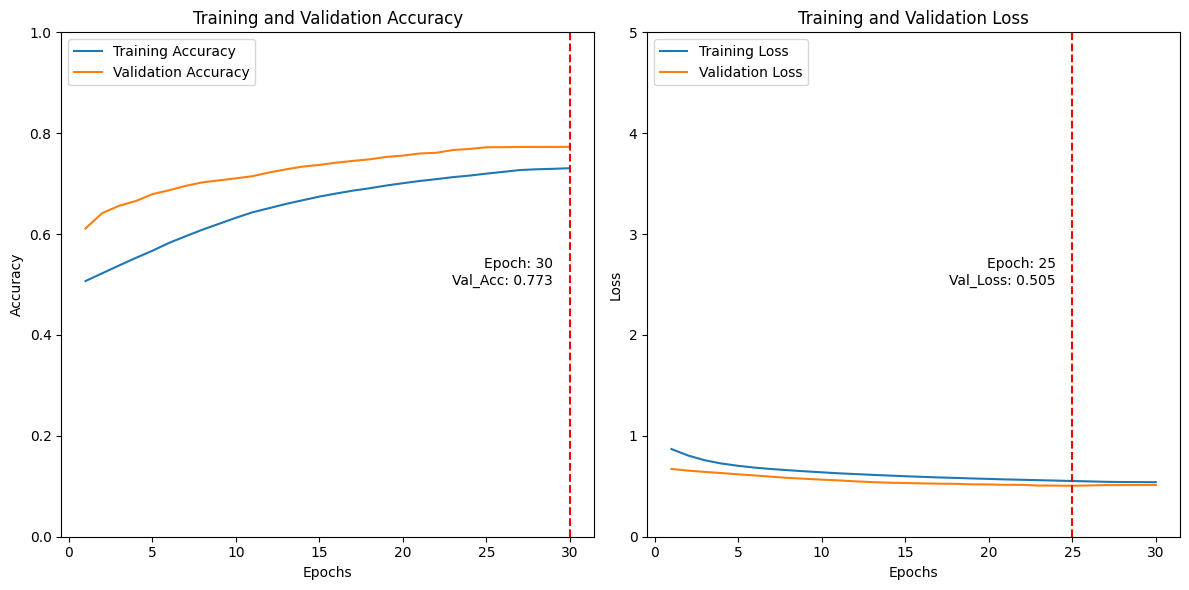

## Evaluación LSTM

In [ ]:
scores = modelLSTM.evaluate(X_test, Y_test, verbose=1)
print("La precisión del modelo es: %.2f%%" % (scores[1]*100))

10000/10000 [==============================] - 603s 60ms/step - loss: 0.4424 - accuracy: 0.8012
La precisión del modelo es: 80.12%


### Gráficos

Last epoch - loss: 0.256, accuracy: 0.89, validation loss: 0.493, validation accuracy: 0.802


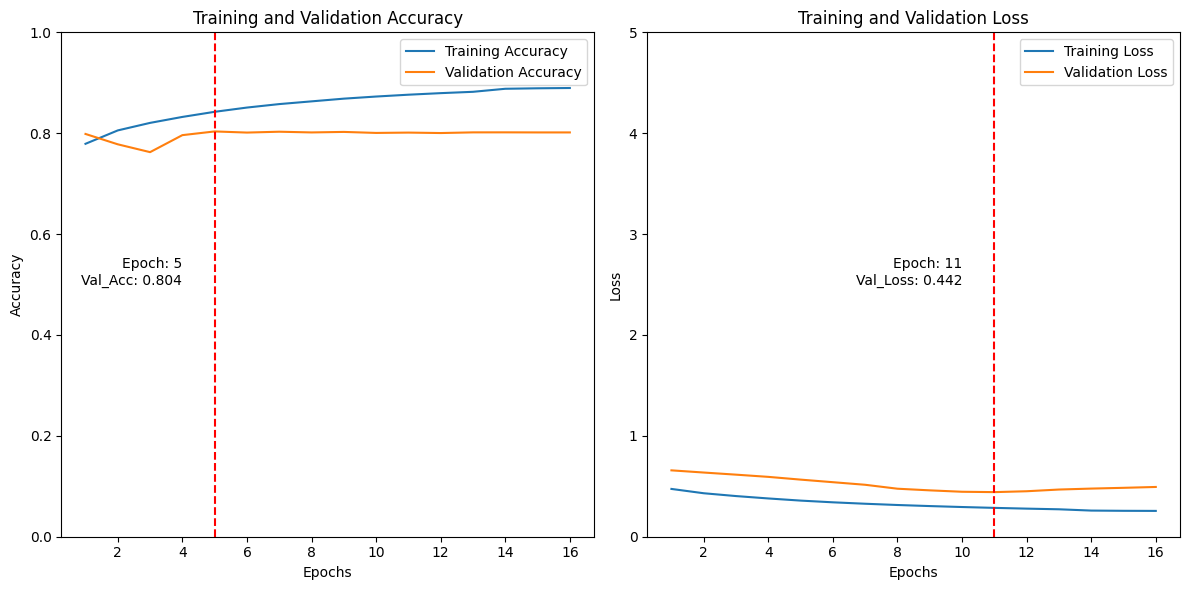

## Conclusión de la comparación entre ambos modelos

La comparación de los resultados de los modelos RNN y LSTM muestra que ambos han obtenido resultados bastante buenos en la mayoría de las muestras, con solo unos pocos errores (LSTM: 1 error; RNN: 2 errores). Sin embargo, se observa que el modelo LSTM obtiene una precisión mayor del 80.12%, lo que indica que es mejor que el modelo RNN con una precisión del 77.21%. Aunque ambos modelos presentan indicios de overfitting, el modelo LSTM muestra una mayor tendencia a generar overfitting que el modelo RNN, lo que debe ser tenido en cuenta al entrenar el modelo y ajustar los parámetros correspondientes. En conclusión, se puede afirmar que el modelo LSTM es mejor en términos de precisión y una menor pérdida a pesar de los problemas mencionados de overfitting, siendo la mejor opción para este caso en particular.

## Conclusión final


Este trabajo abordó el desafío de clasificar sentimientos en tweets, una tarea común de Procesamiento de Lenguaje Natural (NLP) que tiene numerosas aplicaciones prácticas, como la monitorización de las opiniones en redes sociales, análisis de sentimientos del cliente, entre otros.

Iniciamos con la importación de los datos, cargándolos en un DataFrame de pandas. Esta etapa es crucial en cualquier proyecto de aprendizaje automático o NLP, ya que establece el escenario para las etapas posteriores de preprocesamiento y modelado.

La siguiente etapa, el preprocesamiento, es una etapa crítica en cualquier tarea de NLP. Aquí, realizamos diversas operaciones de limpieza y preparación del texto para su posterior modelado, incluyendo la eliminación de URL, números, menciones, hashtags y puntuación, así como la lematización de las palabras y la conversión de todo el texto a minúsculas. Adicionalmente, codificamos las etiquetas de sentimientos a valores numéricos para facilitar el entrenamiento del modelo. Las funciones auxiliares fueron clave para transformar los textos a secuencias numéricas y viceversa, una operación crucial para alimentar los modelos de redes neuronales.

La división de los datos en conjuntos de entrenamiento y prueba es un paso estándar en cualquier proyecto de aprendizaje automático, que permite evaluar el rendimiento de los modelos en datos no vistos anteriormente.

Posteriormente, se procedió a la implementación y entrenamiento de dos tipos de redes neuronales recurrentes: una Red Neuronal Recurrente simple (RNN) y una Red Neuronal Recurrente de Memoria a Largo Plazo (LSTM). Ambos modelos demostraron una buena precisión, con la LSTM superando ligeramente a la RNN simple. Esta diferencia es esperada, dado que las LSTM están diseñadas para manejar mejor las dependencias a largo plazo en secuencias de texto, que son comunes en tareas de NLP.

En resumen, este trabajo proporcionó una valiosa experiencia práctica en el preprocesamiento de datos de texto y el entrenamiento de modelos de NLP, demostrando las capacidades de las redes neuronales recurrentes para tareas de clasificación de sentimientos. Aunque se presentaron ciertos indicios de sobreajuste, los modelos en general mostraron un buen rendimiento, destacando el potencial de las técnicas de aprendizaje profundo en el campo del procesamiento del lenguaje natural.

Las lecciones aprendidas de este trabajo incluyen la importancia de un preprocesamiento de datos efectivo, el valor de la elección apropiada de la arquitectura del modelo en función de la tarea a realizar, y la necesidad de monitorizar y manejar posibles problemas como el sobreajuste. Estos son principios importantes que son aplicables a una amplia gama de tareas en el aprendizaje automático y NLP.